In [2]:
"""Demonstrate how probabilistic solvers work via conditioning on constraints."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend

from probdiffeq import ivpsolve, ivpsolvers, stats, taylor

### Quick Start quide

In [3]:
"""Solve the logistic equation."""

@jax.jit
def vf(y, *, t):  # noqa: ARG001
    """Evaluate the dynamics of the logistic ODE."""
    return y * (1 - y)


u0 = jnp.asarray([0.01])
t0, t1 = 0.0, 10.0
N = 20
h = (t1 - t0) / N
grid = jnp.linspace(t0, t1, N + 1) #for naive fixed grid computation


# compute the taylor expansion up to order num at t=t0, this is e.g. the ideal initalization for the q-times IWP. 
# equivalent to X_0
tcoeffs = taylor.odejet_padded_scan(lambda y: vf(y, t=t0), (u0,), num=2)

# sets up the prior which is a q-times IWP where q is defined by the initialization tcoeffs. 
# The return should be the discretized SSM specified by (A, b, Q)
# what is init?: init contains the tcoeffs again (might differ for differnet priors) and the cholesky decomposition of the inital covariance, hence P_0^{1/2}
# what is ibm?:
# what is ssm?:
init, ibm, ssm = ivpsolvers.prior_wiener_integrated(tcoeffs, ssm_fact="dense")

# Build a solver
ts = ivpsolvers.correction_ts1(vf, ssm=ssm, ode_order=1)
strategy = ivpsolvers.strategy_filter(ssm=ssm)
solver = ivpsolvers.solver(ssm=ssm, strategy=strategy, prior=ibm, correction=ts)
adaptive_solver = ivpsolvers.adaptive(solver, ssm=ssm)



solution = ivpsolve.solve_fixed_grid(init, grid=grid, solver=solver, ssm=ssm)

# Look at the solution
print(f"\ninitial = {jax.tree.map(jnp.shape, init)}")
print(f"\nsolution = {jax.tree.map(jnp.shape, solution)}")


initial = Normal(mean=(3,), cholesky=(3, 3))

solution = IVPSolution(t=(21,), u=[(21, 1), (21, 1), (21, 1)], u_std=[(21, 1), (21, 1), (21, 1)], output_scale=(20,), marginals=Normal(mean=(21, 3), cholesky=(21, 3, 3)), posterior=Normal(mean=(21, 3), cholesky=(21, 3, 3)), num_steps=(20,), ssm=FactImpl(name='dense', prototypes=<probdiffeq.impl._prototypes.DensePrototype object at 0x12398a270>, normal=<probdiffeq.impl._normal.DenseNormal object at 0x12398a3c0>, stats=<probdiffeq.impl._stats.DenseStats object at 0x12398a510>, linearise=<probdiffeq.impl._linearise.DenseLinearisation object at 0x12398a120>, conditional=<probdiffeq.impl._conditional.DenseConditional object at 0x12398a900>, num_derivatives=2, unravel=<jax._src.util.HashablePartial object at 0x123ca4640>))


u_array_squeezed shape: (3, 21)
u_std_squeezed shape: (3, 21)


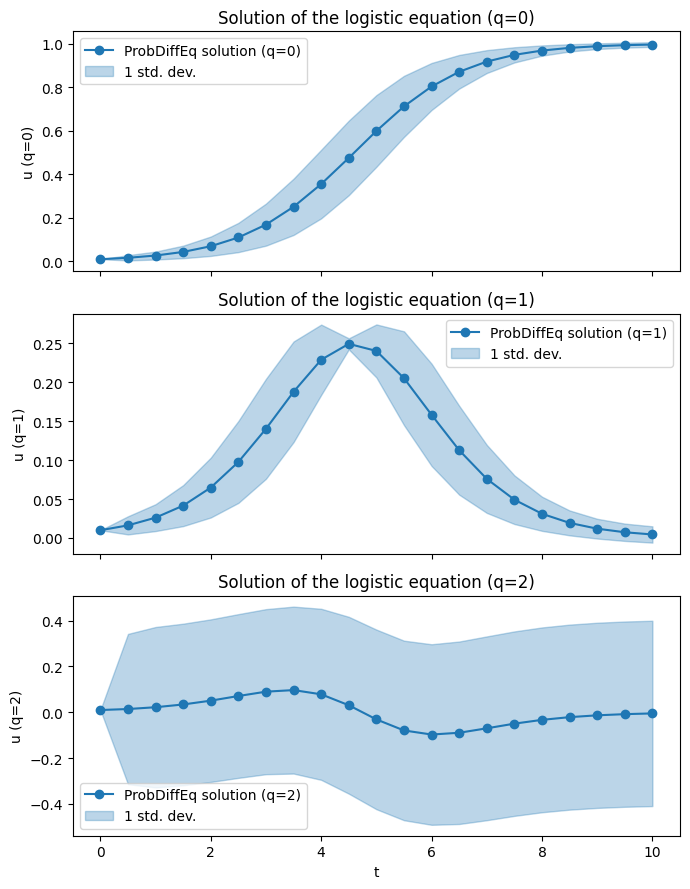

In [19]:
# Convert solution.u (a list) to a JAX array and squeeze to remove singleton dimensions
u_array = jnp.asarray(solution.u)
u_array_squeezed = jnp.squeeze(u_array)  # shape: (q, N+1) if q > 1
print("u_array_squeezed shape:", u_array_squeezed.shape)

# Convert solution.t to a JAX array if it's not already
t_array = jnp.asarray(solution.t)

# Convert solution.u_std to a JAX array and squeeze to match u_array_squeezed
u_std_array = jnp.asarray(solution.u_std)
u_std_squeezed = jnp.squeeze(u_std_array)  # shape: (q, N+1) if q > 1
print("u_std_squeezed shape:", u_std_squeezed.shape)

q = u_array_squeezed.shape[0] if u_array_squeezed.ndim > 1 else 1

fig, axes = plt.subplots(q, 1, figsize=(7, 3 * q), sharex=True)
if q == 1:
    axes = [axes]

for i in range(q):
    ax = axes[i]
    u_i = u_array_squeezed[i] if q > 1 else u_array_squeezed
    std_i = u_std_squeezed[i] if q > 1 else u_std_squeezed
    ax.plot(t_array, u_i, marker='o', label=f'ProbDiffEq solution (q={i})')
    ax.fill_between(
        t_array,
        u_i - std_i,
        u_i + std_i,
        color='C0',
        alpha=0.3,
        label='1 std. dev.'
    )
    ax.set_ylabel(f'u (q={i})')
    ax.legend()
    ax.set_title(f'Solution of the logistic equation (q={i})')

axes[-1].set_xlabel('t')
plt.tight_layout()
plt.show()


### my naive impelentation:

In [ ]:
#ODE - IVP:
vf = lambda x: x*(1-x)
y0 = 0.01

#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))
exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

#Prior
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 1.0
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = X_0
Sigma_0 = np.eye(3)*0.

#Discretization
t0, t1 = 0.0, 10.0
N = 20
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[2*X[0] - 1, 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)